In [ ]:
# import numerical functions, plotting functions and statistical functions
import numpy as np
# !pip install pip
# !pip install --upgrade pip
# !pip install scipy
import scipy as sp
import scipy.stats
import pandas as pd

# !pip install pystan
import stan
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# !pip install arviz
import arviz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [ ]:
# !pip uninstall numba
# !pip install --upgrade numba

In [ ]:
def diagnose(name):
    if 'disease' in name:
        return 1
    else:
        return 0

In [ ]:
raw_df = pd.read_csv('./data/kidney_countdata.txt', sep='\t', quotechar='"')
raw_df.rename(columns={'Unnamed: 0': 'gene'}, inplace=True)

meta_df = pd.read_csv('./data/kidney_metadata.txt', sep='\t', quotechar='"')
meta_df.rename(columns={'Unnamed: 0': 'ROI'}, inplace=True)
meta_df['diagnosis'] = meta_df['slide name'].map(diagnose)

In [ ]:
print(meta_df['diagnosis'].value_counts())
print(meta_df['slide name'].value_counts())
sns.histplot([str(x) for x in meta_df['diagnosis'].values])
plt.title('Histogram of Diagnosis')
plt.show()

sns.histplot(meta_df['slide name'])
plt.title('Counts of ROIs from each individual')
plt.show()

In [ ]:
test_ROIs = meta_df[(meta_df['slide name'] == 'disease2B') | (meta_df['slide name'] == 'normal2B')]['ROI'].values

# Option 2:
# d_vals = meta_df[meta_df['diagnosis'] == 1]['ROI'].values
# d_vals = np.random.permutation(d_vals)
# d_vals = d_vals[:20]
# n_vals = meta_df[meta_df['diagnosis'] == 0]['ROI'].values
# n_vals = np.random.permutation(n_vals)
# n_vals = n_vals[:20]
# test_ROIs = np.concatenate((d_vals, n_vals))
# print(meta_df.head())
print(test_ROIs)

We develop a multinomial model where the health status (Normal or Diseased) associated with a sample $m$ is the dependent variable $Y_m\in\{0,1\}$ and the independent variable $X^m$ is the gene expression of the sample. We will model a score $Z=\beta\cdot X$, which can be converted into a probability of $Y_m$ given $(X^m,\beta)$. In our initial implementation, we model the $\beta$ values as being drawn from a normal distribution. Our model is therefore:
$$Y\in\{0, 1\}$$
$$Y^i\sim\text{Bernoulli}\left(\rho_i\right)$$
$$Z_i=\sum_j x_j^iB_j$$
$$P\left(Y_i\right)=\text{logit}\left(Z_i\right)$$
$$B_j\sim N\left(0,\sigma\right)$$
$$\sigma=1$$

In [ ]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_code = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ normal(0, 1);
    beta ~ normal(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [ ]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_laplace = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ double_exponential(0, 1);
    beta ~ double_exponential(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [183]:
# df = raw_df.head(10)
df = raw_df
threshold = 1
column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) > 0 and col not in test_ROIs]
test_column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) > 0 and col in test_ROIs]
print(len(column_list))

# # Option 1: normalize by sum of all counts for an ROI, multiplied by 1,000 to prevent underflow
# X = [(df[col]*1000/sum(df[col])).tolist() for col in column_list]
# test_X = [(df[col]*1000/sum(df[col])).tolist() for col in test_column_list]
# print(len(X))

# Option 2: normalize using z-score method:
X = [sp.stats.zscore(df[col]).tolist() for col in column_list]
test_X = [sp.stats.zscore(df[col]).tolist() for col in test_column_list]

# # Option 3: normalize using min-max method:
# X = [((df[col]-min(df[col]))/(max(df[col])-min(df[col]))).tolist() for col in column_list]
# test_X = [((df[col]-min(df[col]))/(max(df[col])-min(df[col]))).tolist() for col in test_column_list]

# # Option 4: normalize using quantil method:
# import numpy as np
# from scipy.stats.mstats import mquantiles

# def normalize(data, norm_method="quant", desired_quantile=0.75):
#     if norm_method == "quant":
#         quantiles = mquantiles(data, prob=[desired_quantile])

#         normalized_data = np.interp(data, quantiles, [0, 1])
#         return normalized_data
#     else:
#         raise ValueError("Unsupported normalization method")

# X = [normalize(df[col]).tolist() for col in column_list]
# test_X = [normalize(df[col]).tolist() for col in test_column_list]

Y = []
for col in column_list:
    Y.append(int(meta_df[meta_df['ROI']==col]['diagnosis'].values[0]))

test_Y = []
for col in test_column_list:
    test_Y.append(int(meta_df[meta_df['ROI']==col]['diagnosis'].values[0]))

# print(Y)
print(len(Y))

# print(X)
print(len(X))
print(len(X[0]))

204
204
204
18642


In [184]:
import json
data = {'N': len(X), 'q': len(df), 'X': X, 'Y': Y}

with open("/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/genes/model_norm/model_norm.data.json", "w") as f:
    json.dump(data, f)

In [ ]:
model = stan.build(model_laplace, data={'N': len(X), 'q': len(df), 'X': X, 'Y': Y})

In [ ]:
fit = model.sample(num_chains=4, num_samples=1000)

In [ ]:
fit_az = arviz.from_pystan(fit)
arviz.summary(fit_az)

In [185]:
t_out = pd.read_csv("/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output.csv",
                    comment='#')
print(t_out.head())
print(len(t_out))
t_betas = [t_out[col][0] for col in t_out.columns if 'beta' in col]
print(max(t_betas))
abs_betas = np.abs(t_betas)
np_betas = np.array(t_betas)
genes_to_use = df[abs_betas > 0.01]['gene']
t_betas_to_use = np_betas[abs_betas > 0.01]


      lp__         alpha    beta.1        beta.2        beta.3        beta.4  \
0 -7.00542 -3.572360e-08 -0.024306  1.534780e-11  8.239680e-09 -3.627200e-12   

         beta.5        beta.6        beta.7        beta.8  ...    z.195  \
0 -9.928970e-09 -2.264130e-11 -3.671840e-13 -3.286450e-11  ...  10.9275   

     z.196    z.197    z.198    z.199    z.200    z.201   z.202    z.203  \
0  7.29737  10.0059  5.19541  8.76131  9.23094  4.42867  3.4662  8.77926   

     z.204  
0  8.28779  

[1 rows x 18848 columns]
1
0.115995


In [ ]:
# p_betas = [np.mean(x) for x in fit['beta']]
# sns.histplot(p_betas, label='sampled')
sns.histplot(t_betas, label='optimized')
plt.show()

sns.histplot(np.abs(t_betas), label='optimized')

In [ ]:
az.plot_trace(fit_simple_az, var_names=['alpha', 'beta', 'sigma']);
plt.tight_layout()

In [ ]:
# any diverging transitions?
print("Number of diverging samples: {}".format(fit['divergent__'].sum()))

In [ ]:
print(len(fit['beta']))

In [ ]:
# posterior of z
plt.figure(figsize=(4, 4))
sns.kdeplot(fit['beta'][:])
plt.xlabel(r"$\beta$")
plt.ylabel("Posterior density")
sns.despine()
plt.legend()

In [ ]:
# viz_scatter()
from sklearn.metrics import confusion_matrix
import random

correct_guesses = 0
total_guesses = 0
# add simulated data points
for i in range(10):
    idx = np.random.randint(0, 4000)
    scaled = [fit['beta'][:, idx] * x[:] for x in X]
    z = [fit['alpha'][0, idx] + sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
#     r = [random.random() for _ in range(len(Y_tilde))]
#     correct_guesses += len(r[r < Y_tilde])
#     total_guesses += len(r)

# print(correct_guesses / total_guesses)

plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# sns.despine()

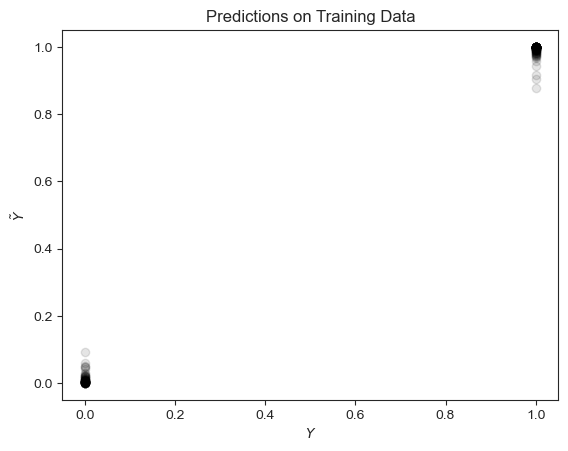

In [186]:
correct_guesses = 0
total_guesses = 0
# add simulated data points

scaled = [np.array(t_betas) * x[:] for x in X]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

plt.show()

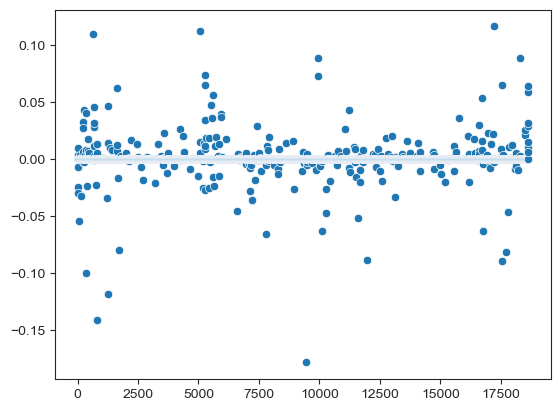

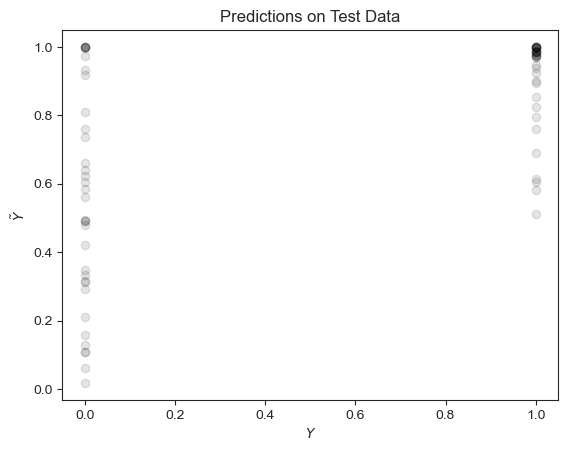

                            ROI  Y      P(Y)  accuracy  samples
0   DSP-1001250007868-B-A12.dcc  1  0.823429         1        1
1   DSP-1001250007868-B-B01.dcc  1  0.989203         1        1
2   DSP-1001250007868-B-B02.dcc  1  0.613211         1        1
3   DSP-1001250007868-B-B03.dcc  1  0.853229         1        1
4   DSP-1001250007868-B-B04.dcc  1  0.977738         1        1
..                          ... ..       ...       ...      ...
67  DSP-1002510007866-C-F03.dcc  0  0.291177         1        1
68  DSP-1002510007866-C-F04.dcc  0  0.315383         1        1
69  DSP-1002510007866-C-F05.dcc  0  0.491475         1        1
70  DSP-1002510007866-C-F06.dcc  0  0.974556         0        1
71  DSP-1002510007866-C-F07.dcc  0  0.211396         1        1

[72 rows x 5 columns]
        P(Y)  accuracy  samples
Y                              
0  19.570540        17       35
1  33.570994        37       37


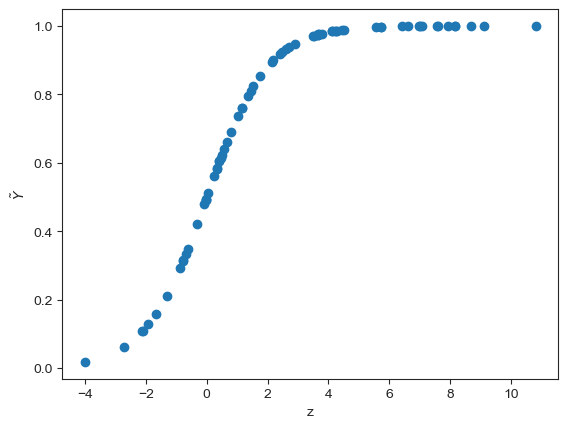

In [187]:
correct_guesses = 0
total_guesses = 0
# add simulated data points
sns.scatterplot(x=[i for i in range(len(t_betas))], y=t_betas)
plt.show()

scaled = [np.array(t_betas) * x[:] for x in test_X]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Test Data')
plt.show()

z.sort()
plt.scatter(z, np.exp(z) / (1 + np.exp(z)))
plt.xlabel('z')
plt.ylabel(r'$\tilde{Y}$')

accuracy = []
for i in range(len(Y_tilde)):
    if Y_tilde[i] > 0.5:
        accuracy.append(1 if test_Y[i] == 1 else 0)
    else:
        accuracy.append(1 if test_Y[i] == 0 else 0)
summary_table = pd.DataFrame({'ROI': test_column_list, 'Y': test_Y, 'P(Y)': Y_tilde, 'accuracy': accuracy, 'samples': 1})
print(summary_table)
s_g = summary_table.groupby('Y').sum()
print(s_g)

In [ ]:
X_to_use = np.array(X)
X_to_use = [x[abs_betas > 0.01] for x in X_to_use]
test_X_to_use = np.array(test_X)
test_X_to_use = [x[abs_betas > 0.01] for x in test_X_to_use]
scaled = [np.array(t_betas_to_use) * x[:] for x in X_to_use]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

print(Y)
print(Y_tilde)
plt.show()

From https://www.cs.bham.ac.uk/~axk/laplace.pdf,
$$_t=\frac{\sum_n(y_n-\sum_{t'\neq t}w_{t'}x_{t'n})x_{tn}}{\sum_n x^2_{tn}}$$


In [ ]:
def 

In [ ]:
print(len(test_X))
test_X_to_use = np.array(test_X)
test_X_to_use = [x[abs_betas > 0.01] for x in test_X_to_use]
scaled = [np.array(t_betas_to_use) * x[:] for x in test_X_to_use]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(test_Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.yscale('log')
plt.title('Predictions on Training Data')

print(Y)
print(Y_tilde)
plt.show()